<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/python/spatial_programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Térinformatikai programozás Python-ban

### Szükséges Python csomagok és adatállományok

In [ ]:
!pip install -q rasterio
!pip install -q open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.7 MB/s eta 0:00:00


In [ ]:
!wget -q http://www.agt.bme.hu/~siki/ullo/odm_orthophoto_25.tif
!wget -q http://www.agt.bme.hu/ftp/foss/mo.zip
!unzip -q mo.zip
!wget -q https://github.com/OSGeoLabBp/tutorials/raw/master/english/data_processing/lessons/code/house.pcd -O sample_data/house.pcd

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, ConvexHull
import rasterio
import rasterio.plot
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium
import rasterio
import open3d as o3d
from math import pi, sin, cos, atan2, hypot
import plotly.graph_objects as go

## Geometriai számítás

Pontok a háromszögben: 11.0% 11 / 100
Háromszög területe: 0.1
Háromszög kerülete: 1.3


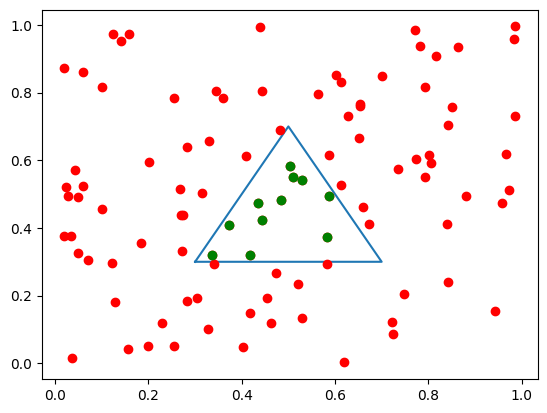

In [ ]:
# Create a point and a polygon
coords = ((0.3, 0.3), (0.7, 0.3), (0.5, 0.7), (0.3, 0.3))
poly = Polygon(coords)
inside = 0
points_inside = []
for point in points:
    if poly.contains(Point(point)):
        points_inside.append(point)
        inside += 1
p_ins = np.array(points_inside)
plt.plot(*poly.exterior.xy)
plt.plot(points[:,0], points[:,1], 'ro')
plt.plot(p_ins[:,0], p_ins[:,1], 'go')
print(f"Pontok a háromszögben: {inside / len(points) * 100:.1f}% {inside} / {len(points)}")
print(f"Háromszög területe: {poly.area:.1f}")
print(f"Háromszög kerülete: {poly.length:.1f}")

## Világtérkép megjelenítése

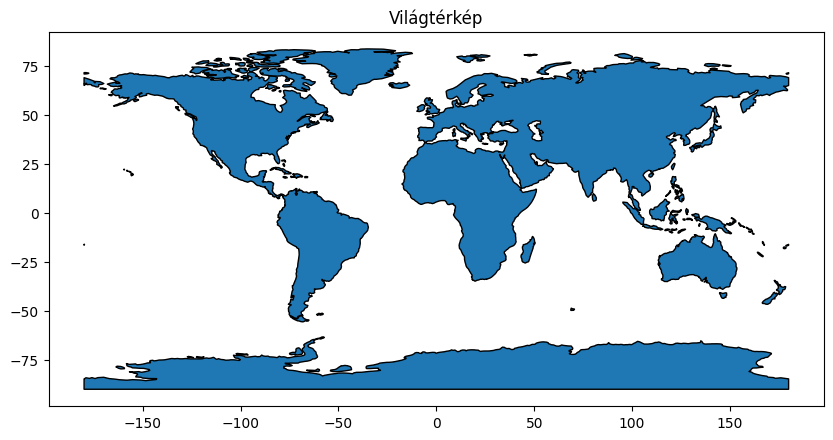

In [ ]:
url = "http://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_land.geojson"
df = gpd.read_file(url)

# Plot the world map
df.plot(figsize=(10, 6), edgecolor='black')
_ = plt.title("Világtérkép")

Text(0.5, 1.0, 'Részlet')

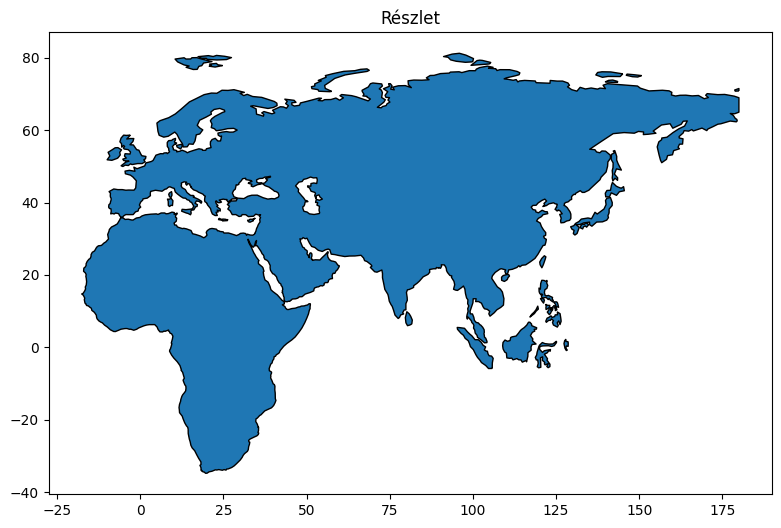

In [ ]:
box = (-10, 0.0, 180.0, 80.0)
df1 = gpd.read_file(url, bbox=box)  # csak a teljesen beleesők
df1.plot(figsize=(10, 6), edgecolor='black')
plt.title("Részlet")

## Interaktív térkép

In [ ]:
# térkép Budapest középponttal
m = folium.Map(location=[47.498, 19.040], zoom_start=10)
# jelek hozzáadása
folium.Marker(location=[47.498, 19.040], popup="Budapest").add_to(m)
folium.Marker(location=[47.4819, 19.0544], popup="Foszforgézu").add_to(m)
# megjelenítés Jupyter jegyzettömbben
m

## Koordináta átszámítás

In [ ]:
from pyproj import Transformer

# ETRS -> EOV
transformer = Transformer.from_crs("EPSG:7931", "EPSG:10660", always_xy=True)
x, y = transformer.transform(19.05652987, 47.48094378)  # BUTE permanens állomás
print(f"EOV koordináták: {x:.2f} {y:.2f}")

EOV koordináták: 650684.60 237444.25


## Térbeli összekapcsolás

Melyik város melyik megyébe esik

In [ ]:
cities = gpd.read_file('varos.shp')
counties = gpd.read_file('megye.shp')

joined = gpd.sjoin(cities, counties, how="left", predicate='within')

print(joined[['NEV', 'Nev']])

                 NEV                     Nev
0             Sopron       Gyõr-Moson-Sopron
1               Gyõr       Gyõr-Moson-Sopron
2        Szombathely                     Vas
3       Zalaegerszeg                    Zala
4               Pécs                 Baranya
5          Szekszárd                   Tolna
6           Veszprém                Veszprém
7          Tatabánya       Komárom-Esztergom
8     Székesfehérvár                   Fejér
9           Budapest                Budapest
10         Kecskemét             Bács-Kiskun
11       Salgótarján                  Nógrád
12           Szolnok    Jász-Nagykun-Szolnok
13            Szeged                Csongrád
14  Hódmezõvásárhely                Csongrád
15              Eger                   Heves
16           Miskolc    Borsod-Abaúj-Zemplén
17       Nyíregyháza  Szabolcs-Szatmár-Bereg
18          Debrecen             Hajdú-Bihar
19        Békéscsaba                   Békés
20          Kaposvár                  Somogy


## Réteg vágása egy másik réteggel

Városok egy megyében.

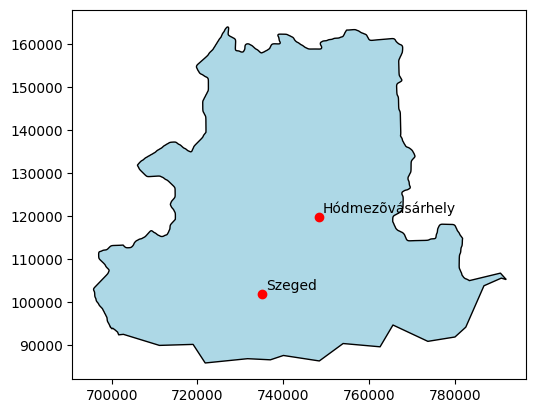

In [ ]:
# Select one country (e.g., France)
csongrad = counties[counties['Nev']=='Csongrád']

# Clip cities to the France boundary
cities_in_csongrad = gpd.clip(cities, csongrad)

# Plot
base = csongrad.plot(color='lightblue', edgecolor='black')
cities_in_csongrad.plot(ax=base, color='red')
for x, y, label in zip (cities_in_csongrad.geometry.x, cities_in_csongrad.geometry.y, cities_in_csongrad['NEV']):
    plt.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

## Övezetkészítés

Folyók 10 km-es környezete

Text(0.5, 1.0, 'Folyók övezetei')

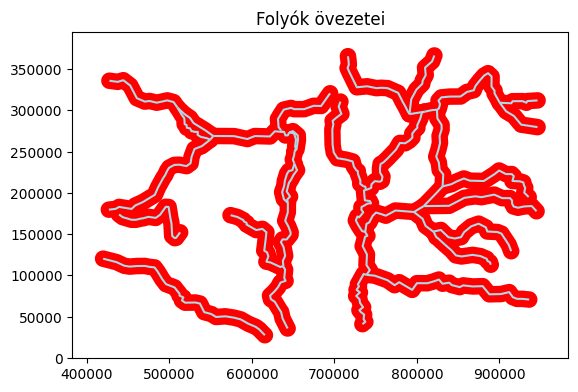

In [ ]:
rivers = gpd.read_file('folyo.shp')
buffer = rivers.buffer(10000)
base = rivers.plot(color='lightblue', edgecolor='black')
buffer.plot(ax=base, color='red')
base.set_title("Folyók övezetei")

## Delaunay háromszögek generálása

### Háromszögrács generálása

In [ ]:
points = np.random.rand(100, 2)
triangles = Delaunay(points)

### Konvex befoglaló idom a pontokra

In [ ]:
hull = ConvexHull(points)

### Háromszögrács és konvex befoglaló idom megjelenítése

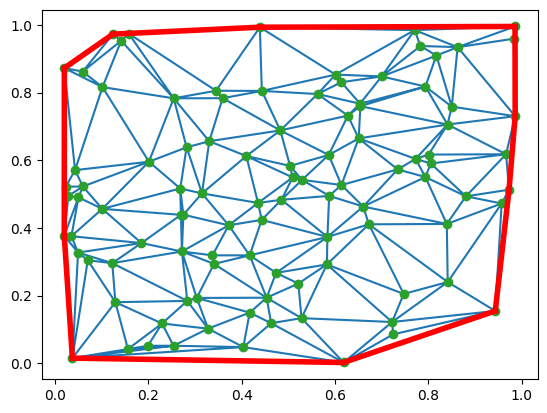

In [ ]:
plt.triplot(points[:,0], points[:,1], triangles.simplices)
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex,0], points[simplex,1], 'r-', linewidth=4)

##Raszter betöltése és megjelenítése

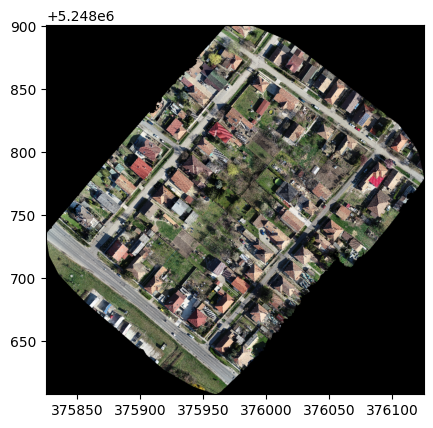

1199 x 1174 x 4 sáv
Határok: 375825.20 5248607.95 376124.96 5248901.43
Vetület: EPSG:32634


In [ ]:
with rasterio.open('odm_orthophoto_25.tif') as src:
    rasterio.plot.show(src)
    print(f"{src.width} x {src.height} x {len(src.indexes)} sáv")
    print(f"Határok: {src.bounds.left:.2f} {src.bounds.bottom:.2f} {src.bounds.right:.2f} {src.bounds.top:.2f}")
    print(f"Vetület: {src.crs}")

## Raszter kalkulációk

Átlag: 2.84, Szórás: 4.58, Min: 0.00, Max: 273.56


(np.float64(-0.5), np.float64(3989.5), np.float64(3989.5), np.float64(-0.5))

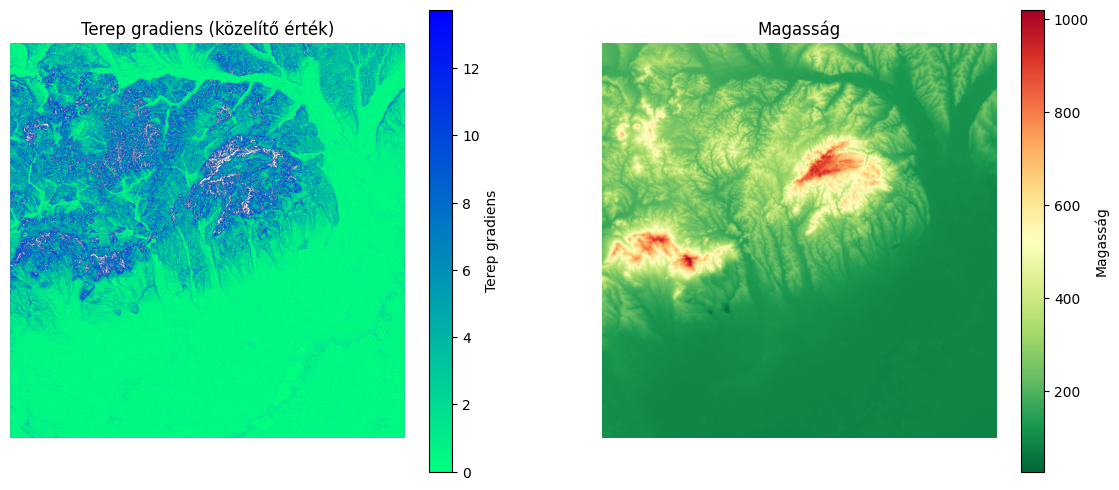

In [ ]:
with rasterio.open('matra.tif') as src:
    dem = src.read(1).astype('float32')  # Sáv 1: magasság

dem[dem == src.nodata] = np.nan
mean_val = np.nanmean(dem)
std_val = np.nanstd(dem)
min_val = np.nanmin(dem)
max_val = np.nanmax(dem)

#print(f"Átlag: {mean_val:.2f}, Szórás: {std_val:.2f}, Min: {min_val:.2f}, Max: {max_val:.2f}")

up = np.roll(dem, -1, axis=0)
down = np.roll(dem, 1, axis=0)
left = np.roll(dem, -1, axis=1)
right = np.roll(dem, 1, axis=1)
slope_like = np.sqrt(((up - down)**2 + (left - right)**2) / 2)
slope_like[np.isnan(dem)] = np.nan
mean_val = np.nanmean(slope_like)
std_val = np.nanstd(slope_like)
min_val = np.nanmin(slope_like)
max_val = np.nanmax(slope_like)
slope_like[slope_like > std_val * 3] = np.nan

print(f"Átlag: {mean_val:.2f}, Szórás: {std_val:.2f}, Min: {min_val:.2f}, Max: {max_val:.2f}")

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
im0 = ax[0].imshow(slope_like, cmap='winter_r')
fig.colorbar(im0, label='Terep gradiens')
ax[0].set_title("Terep gradiens (közelítő érték)")
ax[0].axis('off')
im1 = ax[1].imshow(dem, cmap='RdYlGn_r')
fig.colorbar(im1, label='Magasság')
ax[1].set_title("Magasság")
ax[1].axis('off')

## Pontfelhő megjelenítés

In [ ]:
tolerance = 0.02        # distance from the plane to accept point
iterations = 1000       # number of iterations
n = 1000 # number of inliers
m = 600  # number of outliers
range = 100.0   # range of x, y, z coordinates from zero to range

# points on a horizontal plane
x = np.random.rand(n + m) * range
y = np.random.rand(n + m) * range
z = np.zeros(n + m)
z[0:n] = np.random.rand(n) * tolerance + range / 2.0    # on plane
z[n:n+m] = np.random.rand(m) * range                    # noise
# random rotate points to have general plane
alpha, beta = np.random.randint(10, 80, 2) / 180.0 * pi
r1 = np.array([[1.0, 0.0, 0.0], [0.0, cos(alpha), -sin(alpha)], [0.0, sin(alpha), cos(alpha)]])
r2 = np.array([[cos(beta), 0.0, sin(beta)], [0.0, 1.0, 0.0], [-sin(beta), 0.0, cos(beta)]])
r = r1.dot(r2)
# rotate points
points = np.c_[x, y, z].dot(r)

In [ ]:
fig = go.Figure(data=[go.Scatter3d(x=points[0:n, 0], y=points[0:n, 1],
                                   z=points[0:n, 2], mode='markers',
                                   marker=dict(size=3, color='green')),
                      go.Scatter3d(x=points[n:n+m, 0], y=points[n:n+m, 1],
                                   z=points[n:n+m, 2], mode='markers',
                                   marker=dict(size=2, color='red'))])
# Add title to the axes
fig.update_layout(scene=dict(
                    aspectmode='manual', aspectratio=dict(x=1, y=1, z=1),
                    xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                    width=700, margin=dict(r=20, b=10, l=10, t=10)
)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
if points.shape[1] < 4:
    points = np.c_[points, np.full((n+m, 1), 1)]    # change to homogenouos coord
best_n = 0          # number of points on the best plane so far
best_i = 0          # iteration index of best plane so far
best_inliers = np.array([]) # indices of inliers of the best plane so far
for i in np.arange(iterations):
    # select three random points
    l = []  # list of random indices for points
    while len(l) != 3:
        l = list(set(np.random.randint(n+m, size=3))) # remove repeated random integers
    pp = points[l]  # randomly selected points
    # plane equation from the three points using homogenouos coordinates
    a = np.linalg.det(pp[:,1:])
    b = -np.linalg.det(pp[:, [0, 2, 3]])
    c = np.linalg.det(pp[:, [0, 1, 3]])
    d = -np.linalg.det(pp[:, 0:3])
    plane = np.array([a, b, c, d])
    plane = plane / np.sqrt(plane[0:3].dot(plane[0:3]))   # normal to unit vector
    # select close points
    inliers = points[np.abs(np.dot(points, plane)) < tolerance]
    if inliers.shape[0] > best_n:
        # better solution found
        best_n = inliers.shape[0]
        best_i = i
        best_inliers = inliers[:,:3].copy()
        best_plane = plane.copy()
print(f'Legjobb megoldás {best_i} iteráció után, {best_n} pont a síkon: {best_plane}')

Best solution after 5 iterations, 1000 points on plane: [ 0.29166535 -0.87470175 -0.38707644 50.01781684]


## Épület keresés pontfelhőben

2237 points left from 7190


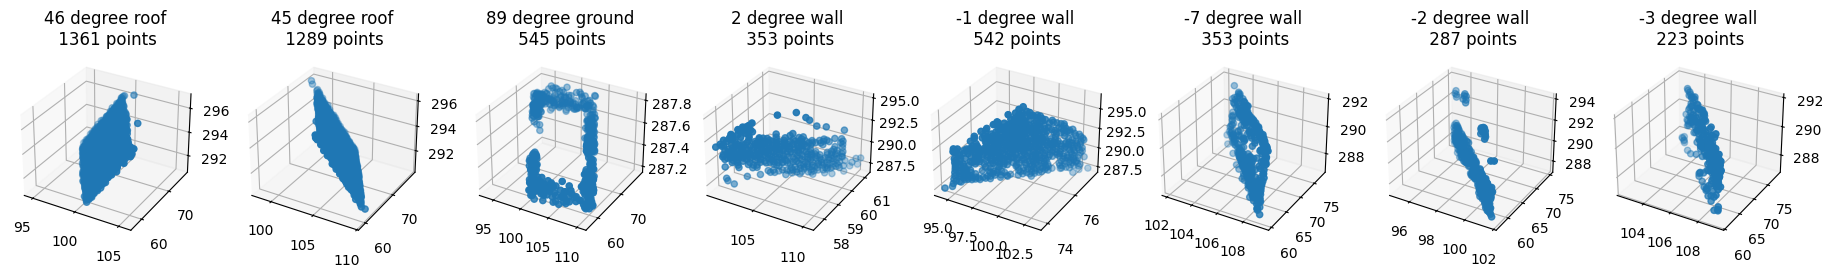

In [ ]:
def label(ang):
    """ return roof/wall/ground label from angle of normal to horizontal """
    label = '???'
    if abs(ang < 15):
        label = 'wall'
    elif 80 < abs(ang) < 100:
        label = 'ground'
    elif 35 < abs(ang) < 55:
        label = 'roof'
    return label

n_planes = 8
tol = 0.1           # tolerance distance from plane
n_points = 3        # number of random points
iterations = 300
# load point cloud
pc = o3d.io.read_point_cloud('sample_data/house.pcd')
n_orig = len(pc.points)
pc_orig = pc.select_by_index([], invert=True)   # make a copy of original
planes = []     # list of result planes
fig = plt.figure(figsize=(23, 3))

i = 0
while i < n_planes:
    plane, inliers = pc.segment_plane(tol, n_points, iterations)
    angle = atan2(plane[2], hypot(plane[0], plane[1])) * 180. / pi  # angle of normal from horizontal
    plane_pc = pc.select_by_index(inliers)
    o3d.io.write_point_cloud('sample_data/plane_' + str(i) + '.pcd', plane_pc) # export planes
    ax = fig.add_subplot(1, n_planes, i+1, projection='3d')
    ax.set_title(f'{angle:.0f} degree {label(angle)}\n {len(inliers)} points')
    xyz = np.asarray(plane_pc.points)
    ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2])
    #ch = plane_pc.compute_convex_hull()
    planes.append([plane, plane_pc])
    pc = pc.select_by_index(inliers, invert=True)   # rest of the point cloud
    i += 1
print(f'{len(pc.points)} points left from {n_orig}')

### Eredmény megjelenítése

In [ ]:
data = []
colors = ['red', 'blue', 'green', 'cyan', 'yellow', 'magenta', 'brown', 'orange']
for i, pp in enumerate(planes):
    xyz = np.asarray(pp[1].points)
    data.append(go.Scatter3d(x=xyz[:, 0], y=xyz[:, 1], z=xyz[:, 2], mode='markers',
                             marker=dict(size=1, color=colors[i % len(planes)])))
fig = go.Figure(data=data)
fig.update_layout(scene=dict(aspectmode='manual', aspectratio=dict(x=1, y=1, z=1),
                    xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                    width=700, margin=dict(r=20, b=10, l=10, t=10))
fig.update_layout(showlegend=False)
fig.show()